In [2]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 24.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import gurobipy as gp
from gurobipy import GRB
import random
import seaborn as sns

In [57]:
from gurobipy import Model

# Initialize the Gurobi model
model = Model("Smart_Home_Optimization")

# Parameters
# Time slots (0-23 hours)
T = range(24)

# Expanded set of appliances
A = ['Refrigerator','Washing Machine', 'Dishwasher', 'Heater', 'Oven','Espresso Machine']

# Electricity prices per time slot (in $ per kWh)
P_t = [0.15 if 0 <= t <= 7 or 22 <= t <= 23 else 0.25 if 16 <= t <= 21 else 0.20 for t in T]

# Adjusted power ratings of appliances (in kW)
P_a = {
    'Washing Machine': 0.5,
    'Dishwasher': 1.3,
    'Refrigerator': 0.7,
    'Heater': 1.5,
    'Oven': 0.8,
    'Espresso Machine': 0.8
}

# Expanded operation windows for appliances
W_a = {
    'Washing Machine': range(10, 24),  # Broader operation window
    'Dishwasher': range(8, 16),       # Broader operation window
    'Refrigerator': T,                 # Refrigerator runs all day
    'Heater': T,                       # Heater runs all day
    'Oven': range(14, 21),             # Oven used for cooking dinner for example
    'Espresso Machine': range(7,9)     # Espresso Machine used in the morning
}
min_run_time = {
    'Washing Machine': 2,   # Minimum 2 hours
    'Dishwasher': 2,        # Minimum 2 hours
    'Refrigerator': 24,     # Must run all day
    'Heater': 24,           # Must run all day
    'Oven': 2 ,             # Minimum 2 hour
    'Espresso Machine': 1   # Minimum 1 hour
}
# Priority values for each appliance (higher value means higher priority)
priority = {
    'Washing Machine': 3,
    'Dishwasher': 2,
    'Refrigerator': 5,
    'Heater': 5,
    'Oven': 3,
    'Espresso Machine': 5
}

# Increased maximum load (in kW)
L_max = 10

# Energy generated by solar panels (in kW) - assuming solar generation during daytime
E_t = [0 if t < 6 or t > 18 else 1 for t in T]

# Max generation capacity of solar panels (in kW)
E_max = 1

# Decision Variables
x_at = model.addVars(A, T, vtype=GRB.BINARY, name="x_at")
C_t_net = model.addVars(T, name="C_t_net")

priority_weight = 0.005  # Weight to scale the priority's influence

# Objective Function: Minimize net electricity cost
model.setObjective(sum(P_t[t] * C_t_net[t] for t in T) -
    sum(priority_weight * priority[a] * x_at[a, t] for a in A for t in T), GRB.MINIMIZE)

# Constraints
# 1. Appliance Operation Window Constraint
for a in A:
    for t in T:
        if t not in W_a[a]:
            model.addConstr(x_at[a, t] == 0, f"Window_{a}_{t}")

# 2. Net Power Consumption Calculation

for t in T:
    model.addConstr(C_t_net[t] == sum(P_a[a] * x_at[a, t] for a in A) - E_t[t], f"NetPower_{t}")

# 3. Load Safety Constraint

for t in T:
    model.addConstr(sum(P_a[a] * x_at[a, t] for a in A) <= L_max, f"Load_{t}")

# 4. Solar Generation Constraint
for t in T:
    model.addConstr(E_t[t] <= E_max, f"Solar_{t}")
# 5. each appliance is scheduled to run for at least the specified minimum time
for a in A:
    model.addConstr(sum(x_at[a, t] for t in T) >= min_run_time[a], f"MinRunTime_{a}")
# 6. Non-negativity. constraint for net power consumption
for t in T:  # Loop through each time slot in the set T
    model.addConstr(C_t_net[t] >= 0, f"NonNegativity_{t}")

# Optimize the model
model.optimize()

# Check if the model has an optimal solution
if model.status == GRB.OPTIMAL:
    print("Optimal Schedule:")

    # Dictionary to store the schedule
    optimal_schedule = {}

    for a in A:
        # Initialize a list for each appliance
        optimal_schedule[a] = []

        print(f"{a}:")

        for t in T:
            if x_at[a, t].X > 0.5:
                print(f" Time Slot {t} - {t+1}h")
                # Append the time slot to the appliance's schedule
                optimal_schedule[a].append(t)

    # Print the optimal schedule
    print("\nOptimal Schedule in Dictionary Format:")
    print(optimal_schedule)
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 167 rows, 168 columns and 545 nonzeros
Model fingerprint: 0x7f65d087
Variable types: 24 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 7.6850000
Presolve removed 167 rows and 168 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 7.275 7.685 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.275000000000e+00, best bound 7.275000000000e+00, gap 0.0000%
Optimal Schedule:
Refrigerator:
 

In [58]:
# Initialize total cost variable
total_cost_before_optimization = 0

# Calculate the cost before optimization
for a in A:  # Loop through each appliance
    for t in T:  # Loop through each time slot
        if t in W_a[a]:  # Check if the appliance runs in this time slot in the preferred window
            total_cost_before_optimization += P_t[t] * P_a[a]

# Print the total cost
print(f"Total Cost of Electricity Before Optimization without heuristic method: ${total_cost_before_optimization:.2f}")

Total Cost of Electricity Before Optimization without heuristic method: $15.30


In [59]:
# Initialize a dictionary to store hourly costs
hourly_costs_before_optimization = {t: 0 for t in T}

# Calculate hourly costs before optimization
for a in A:  # Loop through each appliance
    for t in T:  # Loop through each time slot
        if t in W_a[a]:  # Check if the appliance runs in this time slot in the preferred window
            hourly_costs_before_optimization[t] += P_t[t] * P_a[a]

# Convert the dictionary to a list
hourly_costs_list_before_optimization = [hourly_costs_before_optimization[t] for t in T]

# Print hourly costs
print("Hourly Costs of Electricity Before Optimization:")
print(hourly_costs_list_before_optimization)

Hourly Costs of Electricity Before Optimization:
[0.32999999999999996, 0.32999999999999996, 0.32999999999999996, 0.32999999999999996, 0.32999999999999996, 0.32999999999999996, 0.32999999999999996, 0.44999999999999996, 0.8600000000000001, 0.7000000000000001, 0.8, 0.8, 0.8, 0.8, 0.9600000000000001, 0.9600000000000001, 0.875, 0.875, 0.875, 0.875, 0.875, 0.675, 0.40499999999999997, 0.40499999999999997]


In [60]:
# Calculate the total cost
total_cost_after_optimization = sum(P_t[t] * C_t_net[t].X for t in T)

# Printing the total cost
print(f"Total Cost of Electricity After Optimization: ${total_cost_after_optimization:.2f}")

Total Cost of Electricity After Optimization: $8.58


In [61]:
# Initialize a dictionary to store hourly costs after optimization
hourly_costs_after_optimization = {t: 0 for t in T}

# Calculate hourly costs after optimization
for t in T:  # Loop through each time slot
    # Calculate the total power consumed by all appliances at time t
    total_power_consumed = sum(x_at[a, t].X * P_a[a] for a in A)

    # Calculate the net power consumed from the grid at time t (considering solar generation)
    net_power_consumed = total_power_consumed - E_t[t] if total_power_consumed > E_t[t] else 0

    # Calculate the cost for net power consumed at time t
    hourly_costs_after_optimization[t] = P_t[t] * net_power_consumed

# Convert the dictionary to a list for easy plotting
hourly_costs_list_after_optimization = [hourly_costs_after_optimization[t] for t in T]

# Printing hourly costs
print("Hourly Costs of Electricity After Optimization:")
print(hourly_costs_list_after_optimization)

# Sum the hourly costs to verify it matches the total cost after optimization
print("Sum of Hourly Costs After Optimization:")
print(sum(hourly_costs_list_after_optimization))


Hourly Costs of Electricity After Optimization:
[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.18000000000000002, 0.3, 0.5, 0.5, 0.24000000000000005, 0.24000000000000005, 0.24000000000000005, 0.24000000000000005, 0.4, 0.4, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.55, 0.55, 0.55, 0.405, 0.405]
Sum of Hourly Costs After Optimization:
8.58


In [69]:
# Rank appliances by priority
sorted_appliances = sorted(A, key=lambda x: priority[x], reverse=True)

heuristic_schedule = {a: [] for a in A}
for a in sorted_appliances:
    hours_needed = min_run_time[a]

    if hours_needed == 24:
        heuristic_schedule[a] = list(range(24))
        continue

    # Schedule appliances based on their operation windows
    available_hours = list(W_a[a])
    for hour in available_hours:
        if hours_needed > 0:
            heuristic_schedule[a].append(hour)
            hours_needed -= 1

# Print the heuristic schedule
print("Heuristic Schedule:")
for appliance, hours in heuristic_schedule.items():
    print(f"{appliance}: {sorted(hours)}")

Heuristic Schedule:
Refrigerator: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Washing Machine: [10, 11]
Dishwasher: [8, 9]
Heater: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Oven: [14, 15]
Espresso Machine: [7]


In [71]:
# Calculate cost using the heuristic schedule
# Initialize a dictionary to store hourly costs based on the heuristic schedule
hourly_costs_heuristic = {t: 0 for t in T}

# Calculate hourly costs using the heuristic schedule
for t in T:  # Loop through each time slot
    # Calculate the total power consumed by all appliances at time t
    total_power_consumed_at_t = sum(P_a[a] for a in A if t in heuristic_schedule[a])

    # Calculate the net power consumed from the grid at time t (considering solar generation)
    net_power_consumed_at_t = max(total_power_consumed_at_t - E_t[t], 0)

    # Calculate the cost for net power consumed at time t
    hourly_costs_heuristic[t] = P_t[t] * net_power_consumed_at_t

# Convert the dictionary to a list for easy plotting
hourly_costs_list_heuristic = [hourly_costs_heuristic[t] for t in T]


# Print hourly costs with the heuristic
print("Hourly Costs of Electricity with Heuristic Schedule:")
print(hourly_costs_list_heuristic)

# Sum the hourly costs to verify it matches the total heuristic cost
print("Sum of Hourly Costs with Heuristic Schedule:")
print(sum(hourly_costs_list_heuristic))

Hourly Costs of Electricity with Heuristic Schedule:
[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.18000000000000002, 0.3, 0.5, 0.5, 0.3400000000000001, 0.3400000000000001, 0.24000000000000005, 0.24000000000000005, 0.4, 0.4, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.55, 0.55, 0.55, 0.33, 0.33]
Sum of Hourly Costs with Heuristic Schedule:
8.629999999999999


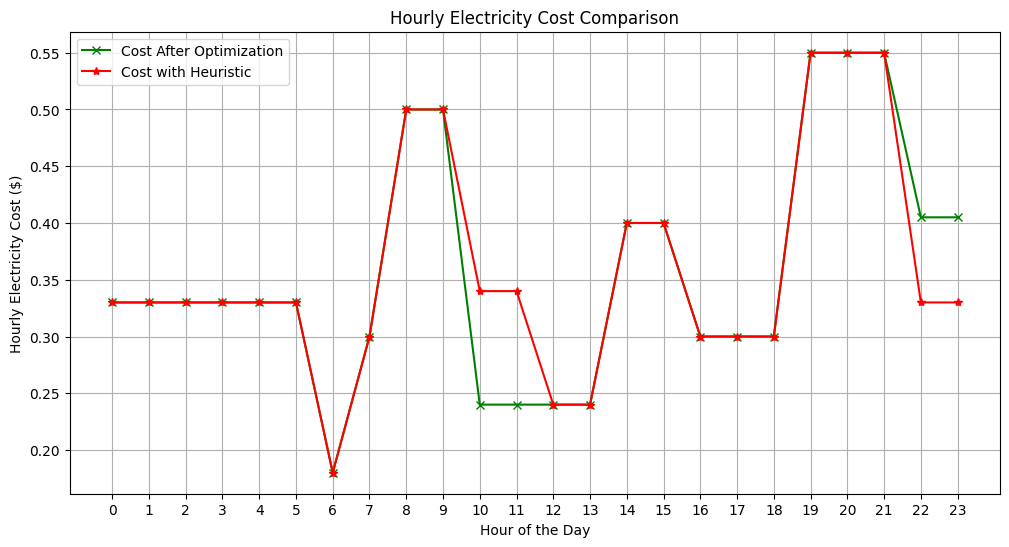

In [97]:
import matplotlib.pyplot as plt

hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x', linestyle='-', color='green')
plt.plot(hours, hourly_costs_list_heuristic, label='Cost with Heuristic', marker='*', linestyle='-', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost Comparison')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()


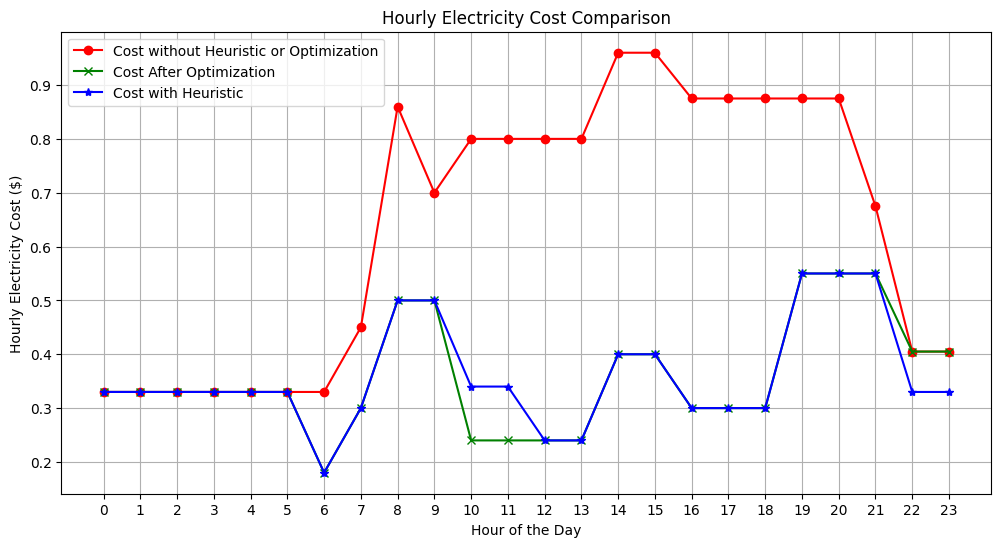

In [95]:
import matplotlib.pyplot as plt

hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
plt.plot(hours, hourly_costs_list_before_optimization, label='Cost without Heuristic or Optimization', marker='o', linestyle='-', color='red')
plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x', linestyle='-', color='green')
plt.plot(hours, hourly_costs_list_heuristic, label='Cost with Heuristic', marker='*', linestyle='-', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost Comparison')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()


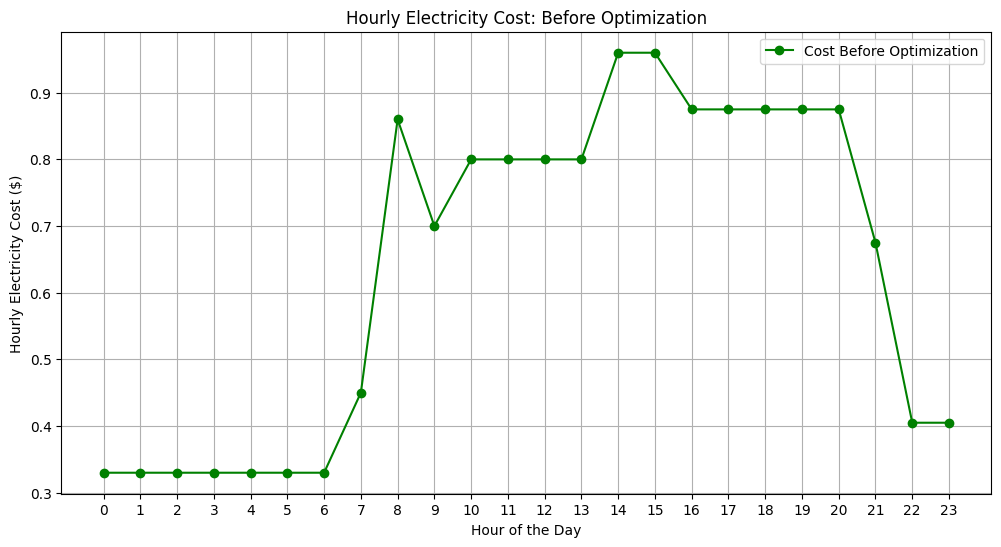

In [73]:
import matplotlib.pyplot as plt

hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
plt.plot(hours, hourly_costs_list_before_optimization, label='Cost Before Optimization', marker='o', color='green')
# plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost: Before Optimization')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()

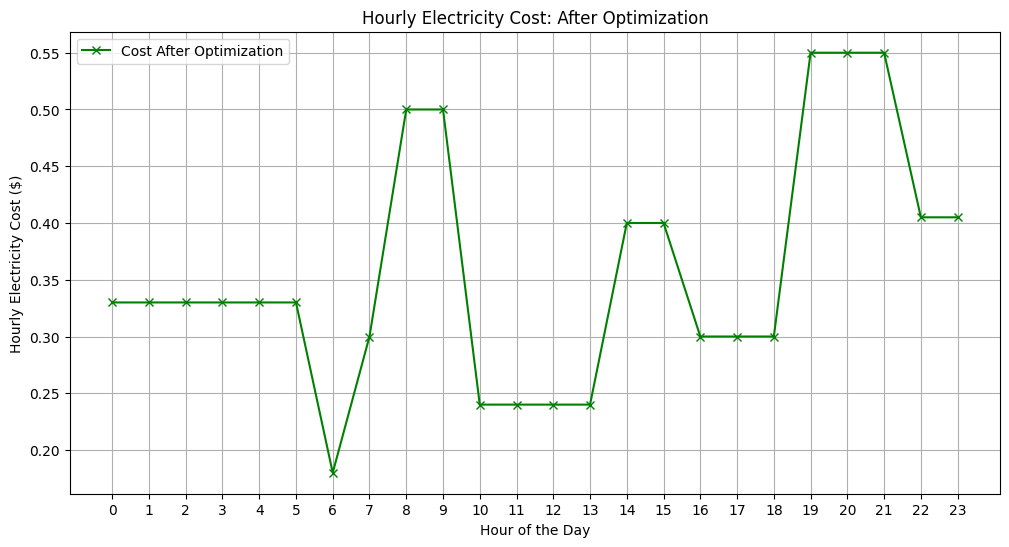

In [74]:
import matplotlib.pyplot as plt

hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
# plt.plot(hours, hourly_costs_list_before_optimization, label='Cost Before Optimization', marker='o')
plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost: After Optimization')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()

In [75]:
# Initialize a list to store total load per hour
total_load_per_hour = [0 for _ in range(24)]

# Calculate total load per hour
for t in range(24):
    for a in A:  # Loop through each appliance
        if x_at[a, t].X > 0.5:  # Check if the appliance is scheduled to run in this time slot
            total_load_per_hour[t] += P_a[a]  # Add the appliance's power rating to the total load for the hour

# Print total load per hour
print("Total Load per Hour (in kW):")
print(total_load_per_hour)

Total Load per Hour (in kW):
[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 3.0, 3.5, 3.5, 2.2, 2.2, 2.2, 2.2, 3.0, 3.0, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.7, 2.7]


In [77]:
# Initialize a list to store total load per hour for the heuristic
total_load_per_hour_heuristic = [0 for _ in range(24)]

# Calculate total load per hour for the heuristic
for a in A:  # Loop through each appliance
    for t in heuristic_schedule[a]:  # Loop through each time slot the appliance is scheduled to run
        total_load_per_hour_heuristic[t] += P_a[a]  # Add the appliance's power rating to the total load for the hour

# Print total load per hour
print("Total Load per Hour (in kW):")
print(total_load_per_hour_heuristic)

Total Load per Hour (in kW):
[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 3.0, 3.5, 3.5, 2.7, 2.7, 2.2, 2.2, 3.0, 3.0, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2]


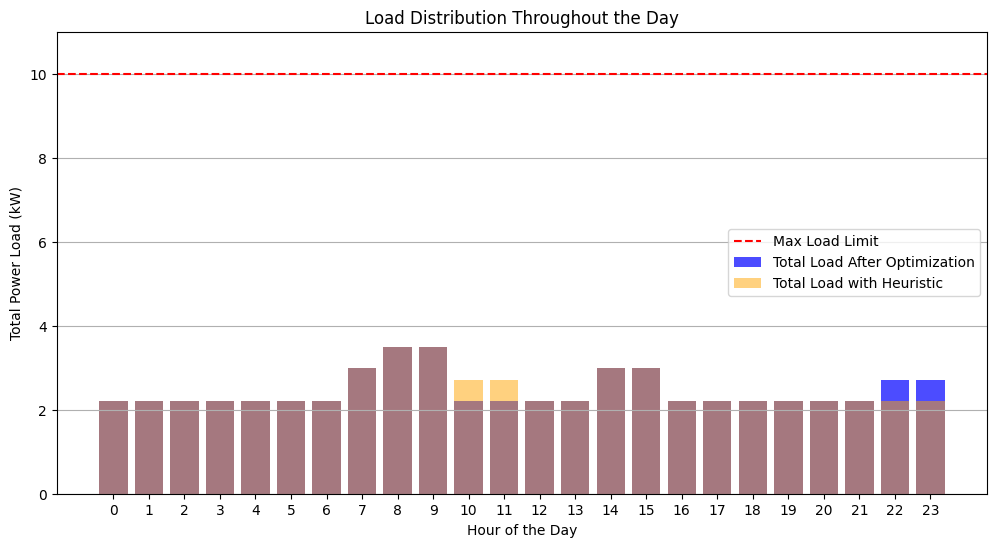

In [78]:
# Plotting the load distribution
plt.figure(figsize=(12, 6))

# Load distribution after optimization
plt.bar(hours, total_load_per_hour, label='Total Load After Optimization', alpha=0.7, color='blue')

# Load distribution according to the heuristic
plt.bar(hours, total_load_per_hour_heuristic, label='Total Load with Heuristic', alpha=0.5, color='orange')

# Maximum load limit line
plt.axhline(y=L_max, color='red', linestyle='--', label='Max Load Limit')

plt.xlabel('Hour of the Day')
plt.ylabel('Total Power Load (kW)')
plt.title('Load Distribution Throughout the Day')
plt.xticks(hours)
plt.ylim(0, max(L_max + 1, max(total_load_per_hour + total_load_per_hour_heuristic) + 1))  # Adjust y-axis limit
plt.grid(True, axis='y')
plt.legend()
plt.show()


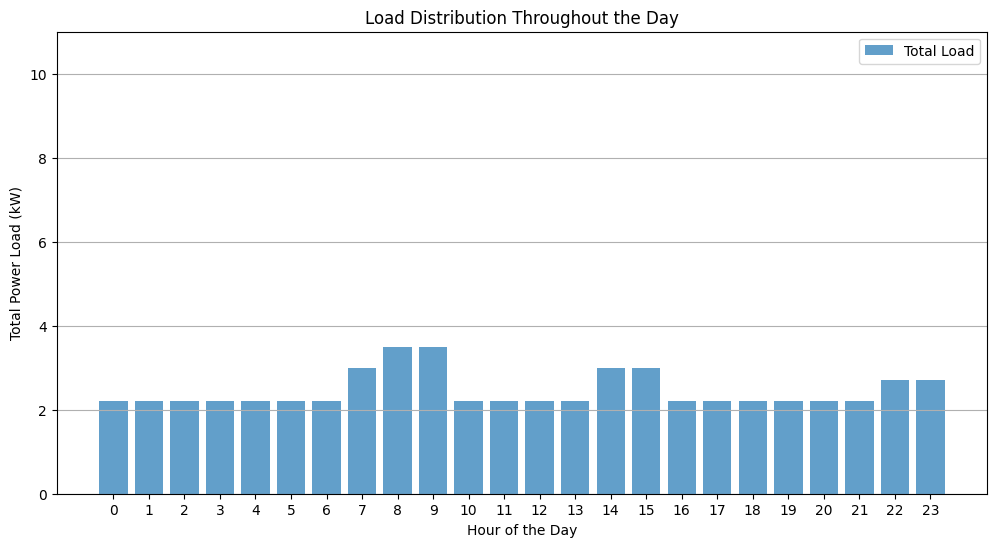

In [79]:
hours = list(range(24))

# Plotting the load distribution
plt.figure(figsize=(12, 6))
plt.bar(hours, total_load_per_hour, label='Total Load',  alpha=0.7)
# plt.axhline(y=L_max, color='red', linestyle='--', label='Max Load Limit')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Power Load (kW)')
plt.title('Load Distribution Throughout the Day')
plt.xticks(hours)
plt.ylim(0, max(L_max + 1, max(total_load_per_hour) + 1))  # Adjusting y-axis limit
plt.grid(True, axis='y')
plt.legend()
plt.show()

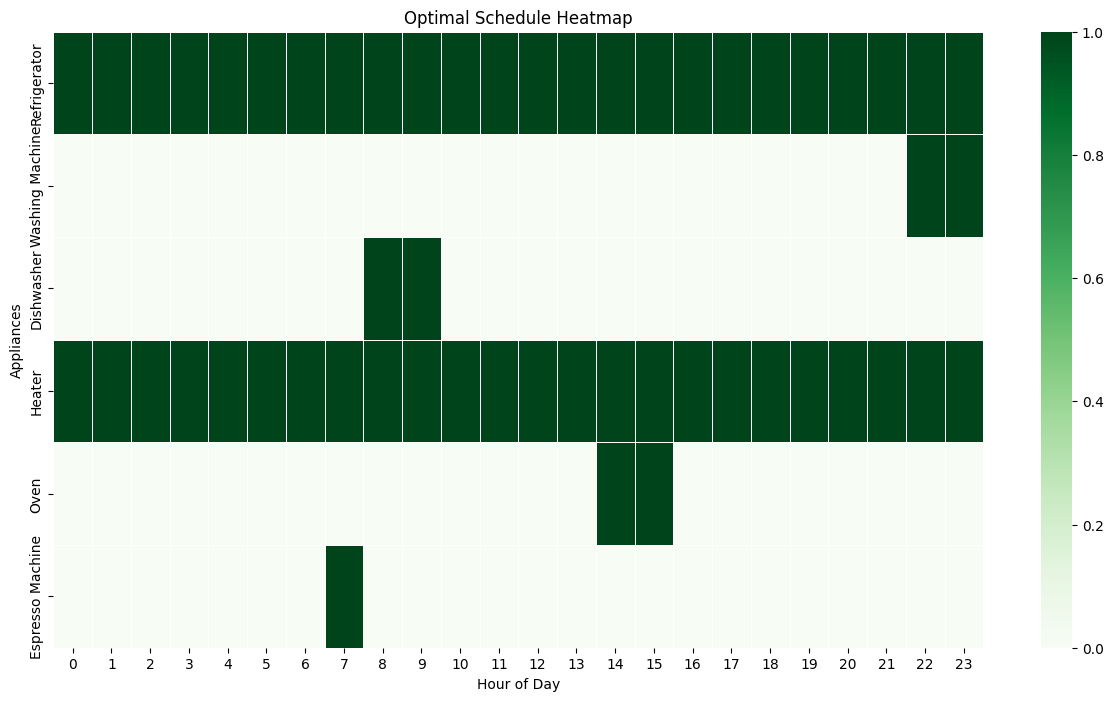

In [80]:
schedule_df = pd.DataFrame(0, index=A, columns=T)

for appliance, time_slots in optimal_schedule.items():
    for t in time_slots:
        schedule_df.at[appliance, t] = 1

# Plotting the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(schedule_df, cmap="Greens", linewidths=0.5, annot=False, fmt="d")

# Adding labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Appliances")
plt.title("Optimal Schedule Heatmap")

# Show the plot
plt.show()

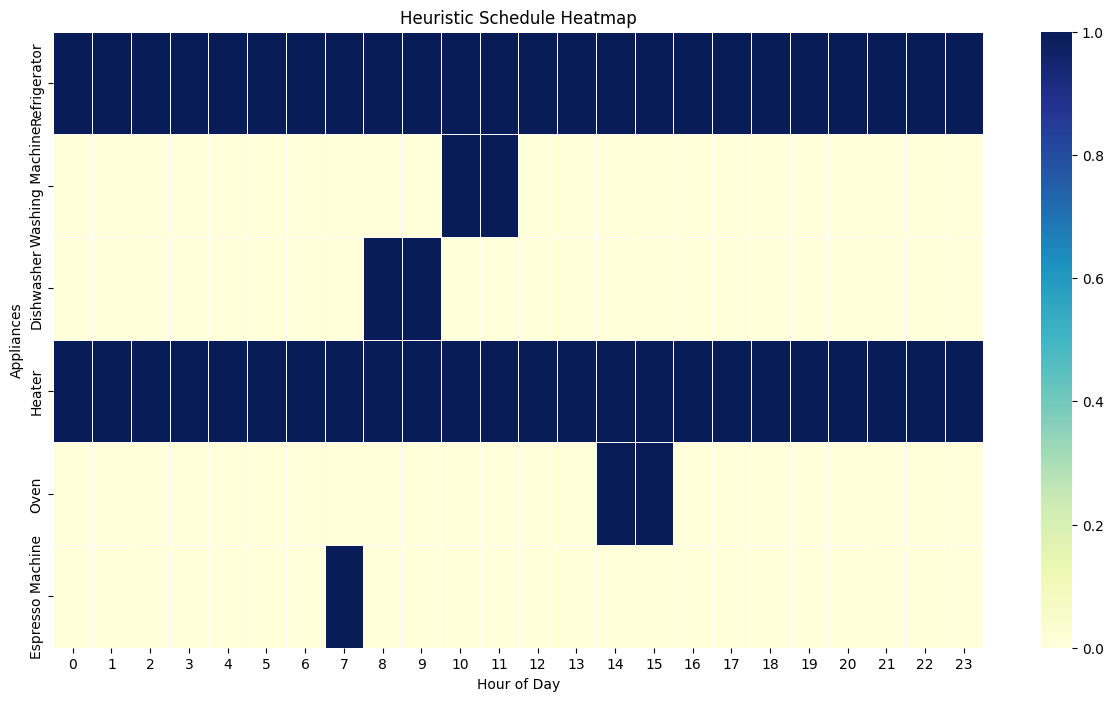

In [81]:
# DataFrame for the heuristic schedule
schedule_df_heuristic = pd.DataFrame(0, index=A, columns=T)

# Fill in the DataFrame with the heuristic schedule
for appliance, time_slots in heuristic_schedule.items():
    for t in time_slots:
        schedule_df_heuristic.at[appliance, t] = 1

# Plotting the heatmap for the heuristic schedule
plt.figure(figsize=(15, 8))
sns.heatmap(schedule_df_heuristic, cmap="YlGnBu", linewidths=0.5)

# Adding labels and title
plt.xlabel("Hour of Day")
plt.ylabel("Appliances")
plt.title("Heuristic Schedule Heatmap")

# Show the plot
plt.show()

### Adding uncertainty to some parameters and constraints

In [82]:
from gurobipy import Model

# Initialize the Gurobi model
model = Model("Smart_Home_Optimization_with_uncertainty")

# Parameters
# Time slots (0-23 hours)
T = range(24)

# Expanded set of appliances
A = ['Refrigerator','Washing Machine', 'Dishwasher', 'Heater', 'Oven','Espresso Machine']

# Electricity prices per time slot (in $ per kWh)
P_t = [0.15 if 0 <= t <= 7 or 22 <= t <= 23 else 0.25 if 16 <= t <= 21 else 0.20 for t in T]

# Adjusted power ratings of appliances (in kW)
P_a = {
    'Washing Machine': 0.5,
    'Dishwasher': 1.3,
    'Refrigerator': 0.7,
    'Heater': 1.5,
    'Oven': 0.8,
    'Espresso Machine': 0.8
}

# Expanded operation windows for appliances
W_a = {
    'Washing Machine': range(10, 24),  # Broader operation window
    'Dishwasher': range(8, 16),       # Broader operation window
    'Refrigerator': T,                 # Refrigerator runs all day
    'Heater': T,                       # Heater runs all day
    'Oven': range(14, 21),             # Oven used for cooking dinner for example
    'Espresso Machine': range(7,9)     # Espresso Machine used in the morning
}
min_run_time = {
    'Washing Machine': 2,   # Minimum 2 hours
    'Dishwasher': 2,        # Minimum 2 hours
    'Refrigerator': 24,     # Must run all day
    'Heater': 24,           # Must run all day
    'Oven': 1 ,             # Minimum 1 hour
    'Espresso Machine': 1   # Minimum 1 hour
}
# Priority values for each appliance (higher value means higher priority)
priority = {
    'Washing Machine': 3,
    'Dishwasher': 2,
    'Refrigerator': 5,
    'Heater': 5,
    'Oven': 3,
    'Espresso Machine': 5
}

# Increased maximum load (in kW)
L_max = 10

# Energy generated by solar panels (in kW) - assuming solar generation during daytime
E_t = [0 if t < 6 or t > 18 else 1 for t in T]

# Max generation capacity of solar panels (in kW)
E_max = 1

# Decision Variables
x_at = model.addVars(A, T, vtype=GRB.BINARY, name="x_at")
C_t_net = model.addVars(T, name="C_t_net")

priority_weight = 0.005  # Weight to scale the priority's influence

# uncertainty range for power consumption rates as a percentage
uncertainty_percentage_P_a = 0.1  # 10% uncertainty

# uncertainty range for solar panel output as a percentage
uncertainty_percentage_E_t = 0.3  # 30% uncertainty

# Objective Function: Minimize net electricity cost
model.setObjective(sum(P_t[t] * C_t_net[t] for t in T) -
    sum(priority_weight * priority[a] * x_at[a, t] for a in A for t in T), GRB.MINIMIZE)

# Constraints
# 1. Appliance Operation Window Constraint
for a in A:
    for t in T:
        if t not in W_a[a]:
            model.addConstr(x_at[a, t] == 0, f"Window_{a}_{t}")

# 2. Net Power Consumption Calculation

# for t in T:
#     model.addConstr(C_t_net[t] == sum(P_a[a] * x_at[a, t] for a in A) - E_t[t], f"NetPower_{t}")

for t in T:
    model.addConstr(
        C_t_net[t] == sum((P_a[a] + uncertainty_percentage_P_a * P_a[a]) * x_at[a, t] for a in A)
        - (E_t[t] - uncertainty_percentage_E_t * E_t[t]),
        f"NetPower_{t}"
    )

# 3. Load Safety Constraint

# for t in T:
#     model.addConstr(sum(P_a[a] * x_at[a, t] for a in A) <= L_max, f"Load_{t}")

# Modify the load safety constraint to account for the uncertainty in power consumption
for t in T:
    model.addConstr(
        sum((P_a[a] + uncertainty_percentage_P_a * P_a[a]) * x_at[a, t] for a in A) <= L_max,
        f"Load_{t}"
    )

# 4. Solar Generation Constraint
for t in T:
    model.addConstr(E_t[t] <= E_max, f"Solar_{t}")
# 5. each appliance is scheduled to run for at least the specified minimum time
for a in A:
    model.addConstr(sum(x_at[a, t] for t in T) >= min_run_time[a], f"MinRunTime_{a}")
# 6. Non-negativity. constraint for net power consumption
for t in T:  # Loop through each time slot in the set T
    model.addConstr(C_t_net[t] >= 0, f"NonNegativity_{t}")

# Optimize the model
model.optimize()

# # Print the solution
# if model.status == GRB.OPTIMAL:
#     print("Optimal Schedule:")
#     for a in A:
#         print(f"{a}:")
#         for t in T:
#             if x_at[a, t].X > 0.5:
#                 print(f" Time Slot {t} - {t+1}h")
# else:
#     print("No optimal solution found.")

# Check if the model has an optimal solution
if model.status == GRB.OPTIMAL:
    print("Optimal Schedule:")

    # Dictionary to store the schedule
    optimal_schedule = {}

    for a in A:
        # Initialize a list for each appliance
        optimal_schedule[a] = []

        print(f"{a}:")

        for t in T:
            if x_at[a, t].X > 0.5:
                print(f" Time Slot {t} - {t+1}h")
                optimal_schedule[a].append(t)

    # Print the optimal schedule
    print("\nOptimal Schedule in Dictionary Format:")
    print(optimal_schedule)
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 167 rows, 168 columns and 545 nonzeros
Model fingerprint: 0x52f06d1d
Variable types: 24 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [6e-01, 2e+00]
  Objective range  [1e-02, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 2e+01]
Found heuristic solution: objective 9.1750000
Presolve removed 167 rows and 168 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 9.032 9.175 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.032000000000e+00, best bound 9.032000000000e+00, gap 0.0000%
Optimal Schedule:
Refrigerator:
 

In [83]:
# Calculate the total cost
total_cost_after_optimization_with_uncertainty = sum(P_t[t] * C_t_net[t].X for t in T)

# Print the total cost
print(f"Total Cost of Electricity After Optimization with uncertainty: ${total_cost_after_optimization_with_uncertainty:.2f}")

Total Cost of Electricity After Optimization with uncertainty: $10.32


In [85]:
# dictionary to store hourly costs
hourly_costs_after_optimization_with_uncertainty = {t: 0 for t in T}

# Calculate hourly costs after optimization
for t in T:  # Loop through each time slot
    # Calculate the total power consumed by all appliances at time t
    total_power_consumed = sum(x_at[a, t].X * P_a[a] for a in A)

    # Calculate the net power consumed from the grid at time t (considering solar generation)
    net_power_consumed = total_power_consumed - E_t[t] if total_power_consumed > E_t[t] else 0

    # Calculate the cost for net power consumed at time t
    hourly_costs_after_optimization_with_uncertainty[t] = P_t[t] * net_power_consumed

# Convert the dictionary to a list
hourly_costs_list_after_optimization_with_uncertainty = [hourly_costs_after_optimization_with_uncertainty[t] for t in T]

# Printing hourly costs
print("Hourly Costs of Electricity After Optimization with uncertainty:")
print(hourly_costs_list_after_optimization_with_uncertainty)

Hourly Costs of Electricity After Optimization with uncertainty:
[0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.18000000000000002, 0.3, 0.5, 0.5, 0.24000000000000005, 0.24000000000000005, 0.24000000000000005, 0.24000000000000005, 0.4, 0.24000000000000005, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.55, 0.55, 0.55, 0.405, 0.405]


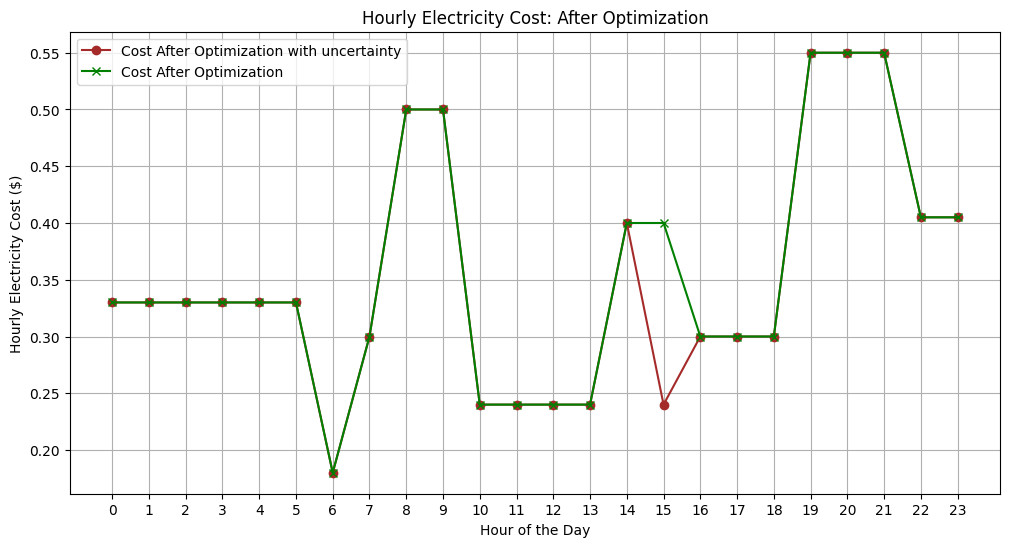

In [88]:
hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
plt.plot(hours, hourly_costs_list_after_optimization_with_uncertainty, label='Cost After Optimization with uncertainty', marker='o', color='brown')
plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x', linestyle='-', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost: After Optimization')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()

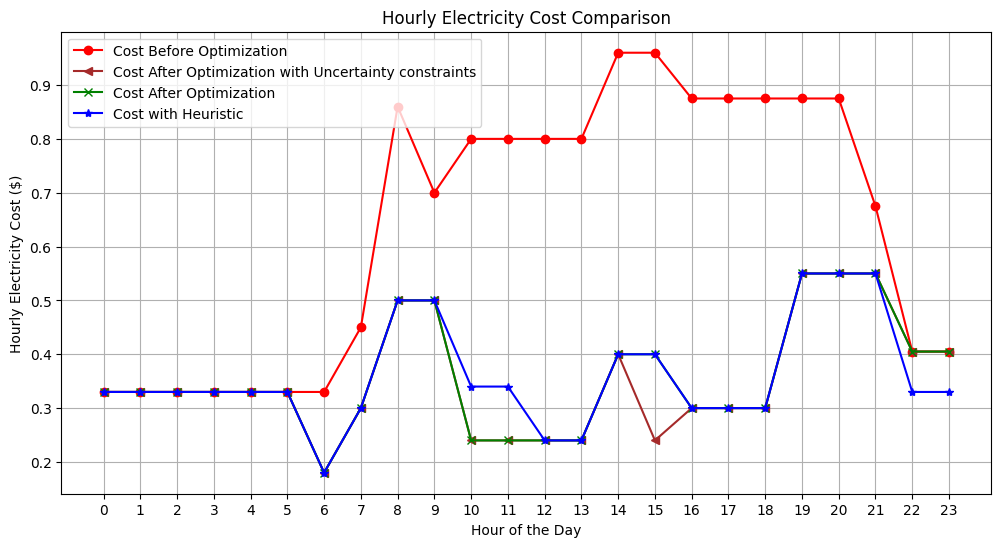

In [86]:
hours = list(range(24))

# Plotting the cost comparison
plt.figure(figsize=(12, 6))
plt.plot(hours, hourly_costs_list_before_optimization, label='Cost Before Optimization', marker='o', linestyle='-', color='red')
plt.plot(hours, hourly_costs_list_after_optimization_with_uncertainty, label='Cost After Optimization with Uncertainty constraints', marker='<', linestyle='-', color='brown')
plt.plot(hours, hourly_costs_list_after_optimization, label='Cost After Optimization', marker='x', linestyle='-', color='green')
plt.plot(hours, hourly_costs_list_heuristic, label='Cost with Heuristic', marker='*', linestyle='-', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Hourly Electricity Cost ($)')
plt.title('Hourly Electricity Cost Comparison')
plt.xticks(hours)
plt.grid(True)
plt.legend()
plt.show()


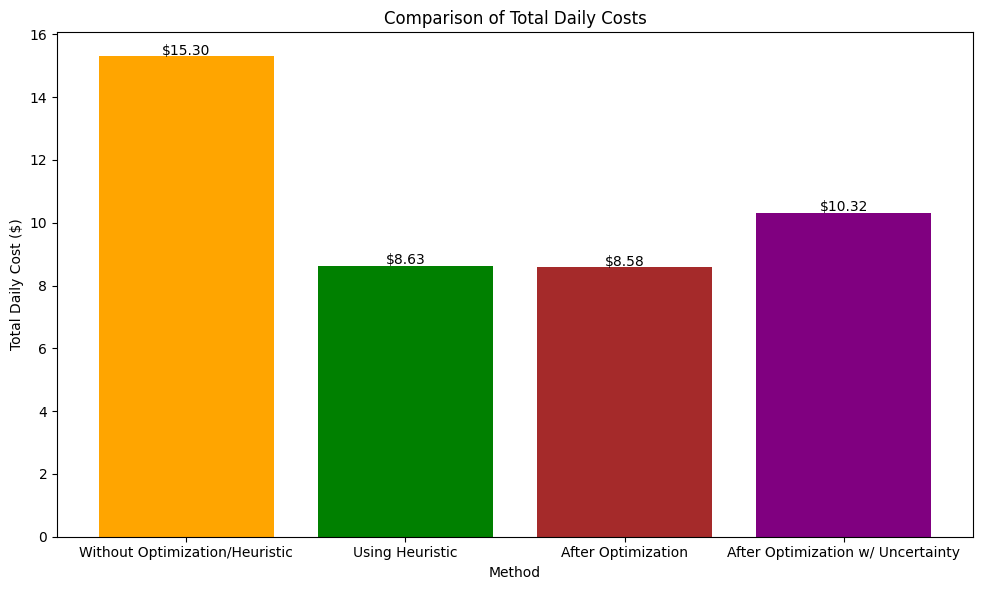

In [94]:
cost_before_optimization = total_cost_before_optimization
cost_with_heuristic = sum(hourly_costs_list_heuristic)
cost_after_optimization = total_cost_after_optimization
cost_after_optimization_uncertainty = total_cost_after_optimization_with_uncertainty

# Labels for the bar chart
cost_labels = ['Without Optimization/Heuristic', 'Using Heuristic', 'After Optimization', 'After Optimization w/ Uncertainty']

# Values corresponding to each label
cost_values = [
    cost_before_optimization,
    cost_with_heuristic,
    cost_after_optimization,
    cost_after_optimization_uncertainty
]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cost_labels, cost_values, color=['orange', 'green', 'brown', 'purple'])

# Adding the title and labels
plt.title('Comparison of Total Daily Costs')
plt.ylabel('Total Daily Cost ($)')
plt.xlabel('Method')

# Displaying the values on top of the bars
for i in range(len(cost_values)):
    plt.text(i, cost_values[i] + 0.05, f'${cost_values[i]:.2f}', ha = 'center')

# Show the plot
plt.tight_layout()
plt.show()
